In [1]:
import plotly.graph_objects as go
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter
import numpy as np
import pdb
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [12]:
advises = pd.read_csv("data/advises.tsv",sep='\t')
academic     = pd.read_csv("data/academic.tsv",sep='\t')
degree_grant = pd.read_csv("data/degree_grant.tsv",sep='\t')
school       = pd.read_csv("data/school.tsv", sep='\t')
country      = pd.read_csv("data/country.tsv", sep='\t')
country2CN = pd.Series(country.country_name.values,index=country.country_id).to_dict()

degree1 = pd.read_csv("data/new_degree.tsv", sep='\t',keep_default_na=True)
degree = degree1.dropna(subset=["year"])

## Gives Full Name
full_name = academic.given_name + " " + academic.family_name
fam_name_D = pd.Series(academic.family_name.values,index=academic.academic_id).to_dict()
given_name_D = pd.Series(academic.given_name.values,index=academic.academic_id).to_dict()
academic["Full_Name"] = full_name
Fullname2ID = pd.Series(academic.academic_id.values, index=academic.Full_Name).to_dict()
full_name_D = pd.Series(full_name.values,index=academic.academic_id).to_dict()

academic2degree = pd.Series(degree1.degree_id.values,index=degree1.academic).to_dict()
degree2school   = pd.Series(degree_grant.school.values,index=degree_grant.degree).to_dict()
school2country  = pd.Series(school.country.values,index=school.school_id).to_dict()
school2SchName  = pd.Series(school.school_name.values,index=school.school_id).to_dict()

In [13]:
adj_list = list(zip(advises["advisee"], advises["advisor"]))
G = nx.DiGraph()
G.add_edges_from(adj_list)

nx.set_node_attributes(G, full_name_D, 'full_name')
G_undirect = G.to_undirected()

In [3]:
medalists     = pd.read_csv("data/medalists.csv",sep=',')
medalist_IDs = []

for i in medalists.Winner.values:
    ID = Fullname2ID[i]
    if i == "Paul Cohen":
        ID = 6479
    if i == "Michael Freedman":
        ID = 1365
    if i == "Alan Baker":
        ID = 22765
    
    if ID == 230591:
        ID = 93772
    if ID == 245820:
        ID = 15779
    if ID == 211588:
        ID = 6488
    G.nodes()[ID]["medalist"] = 1
    medalist_IDs.append(ID)
    
med_adj_list = []
for i in medalist_IDs:
    for j in medalist_IDs:
        if (i,j) in adj_list:
            med_adj_list.append((i,j))
# Gives nodes in subgraph
subgraph = defaultdict(int)
for i, a in enumerate(medalist_IDs):
    subgraph[a] = 1
    for j, b in enumerate(medalist_IDs[i+1:]):
        if nx.has_path(G_undirect,a,b):
            path_nodes = nx.shortest_path(G_undirect,a,b)
            for p in path_nodes:
                subgraph[p] = 1

In [14]:
subgraph_nodes = list(subgraph.keys())
K = G.subgraph(subgraph_nodes)
M = G.subgraph(medalist_IDs)

In [15]:
def extract_year(x):
    try:
        return int(x[:4])
    except:
        return 0
degree2 = degree1.dropna(subset=["year"])
degree2["year"] = degree2.year.apply(extract_year)
degree2["year"] = degree2["year"].astype(int)
degree3 = degree2[degree2['academic'].isin(list(K.nodes))]

C:\Users\Herbert\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Herbert\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Sankey

In [27]:
accept_list = ["United States", "Russia", "Germany", "Japan", "Italy"]

def ID2country(n1):
    try:
        degree_id  = academic2degree[n1]
        school_id  = degree2school[ degree_id ]
        country_id = school2country[ school_id ] 
        return country2CN[country_id]
    except:
        if n1 == 56371:
            return "Germany" 
        
def ID2country_adjusted(x):
    c = accept_list(x)
    if c in accepted_list:
        return c
    else:
        return "Other"
periods = [1800,1932, 1946,  1965, 1990, 2019]

acc2ind = dict(zip(accept_list,range(len(accept_list))))
conf_dict = dict(zip( accept_list, np.ones(len(accept_list),dtype = bool) ))
conf_dict = defaultdict(bool, conf_dict)

P1 = degree3[(degree3.year > periods[0]) & (degree3.year < periods[1])].academic.values
P2 = degree3[(degree3.year > periods[1]) & (degree3.year < periods[2])].academic.values
P3 = degree3[(degree3.year > periods[2]) & (degree3.year < periods[3])].academic.values
P4 = degree3[(degree3.year > periods[3]) & (degree3.year < periods[4])].academic.values
P5 = degree3[(degree3.year > periods[4]) & (degree3.year < periods[5])].academic.values
P_list = [P1, P2, P3, P4,P5]

In [28]:
surs = []
targ = []
vals = []
for ind in range(5):
    edges_c = defaultdict(int)
    node_size = defaultdict(int)

    KK = K.subgraph(P_list[ind])
    for n in KK.nodes():
        neighbors = K.neighbors(n)
        for nei in neighbors:
            try:
                edge_tuple = (ID2country(nei) , ID2country(n)  ) # swapped for advisee-advisor direction
                edges_c[edge_tuple] += 1
            except:
                pass

    D = sorted(edges_c.items(), key=lambda x: x[1], reverse=True)
    val_dict = defaultdict(int)
    for d in D:
        head, tail = d[0][0], d[0][1]
        if not conf_dict[head]:
            continue
            head = "Other"
        if not conf_dict[tail]:
            continue
            tail = "Other"
        val_dict[(head,tail)] += d[1]
    ind = 0

    sources, targets = zip(*list(val_dict.keys()))

    vals_list = [  val_dict[(sources[i], targets[i])] for i in range(len(sources))  ]

    s1 = [acc2ind[k] + ind*len(accept_list) for k in sources]
    t1 = [acc2ind[k] + (ind+1)*len(accept_list) for k in targets] # the +1 is because "other" not added in

    surs.append(s1)
    targ.append(t1)
    vals.append(vals_list)
    
surs_link, targ_link, vals_link = [], [], []
for i in range(len(accept_list)):
    shift = i*len(accept_list)
    surs[i] = [j + shift for j in surs[i]]
    targ[i] = [j + shift for j in targ[i]]
    
    surs_link += surs[i]
    targ_link += targ[i]
    vals_link += vals[i]    

In [29]:
label_short = {"Russia": "RUS", "Italy": "ITA", "United States": "USA", "Germany":" GER", "Japan":"JAP"}

In [30]:
concaters = []
for p in periods:
    for n in accept_list:
        concaters.append(  label_short[n] + "-" + str(p)  )

In [31]:
x = np.repeat(x,len(accept_list)) / 6
y = np.array([1,5,6,7,8]*6)/9

In [25]:
fig = go.Figure(data=[go.Sankey(

    node = {
        "label": concaters,
#         "font_size" : 20,
        "x": x,
        "y": y,
        'pad':15}, 
        link = {
        "source": surs_link,
        "target": targ_link,
        "value": vals_link}
  )])

fig.update_layout(title_text="Migration of Elite Mathematicians", font_size=12)

# Pluralism

In [33]:
WIKI_FULL = pd.read_pickle("data/wiki_fullname.pkl")
Wiki_General = defaultdict(int)
Wiki_Specific = defaultdict(int)
for i, row in WIKI_FULL.iterrows():
    n = row.race
    general_region = n.split(",")[0] 
    specif_region  = n.split(",")[-1] 
    if specif_region == "Jewish":
        n = (row.iloc[4:].sort_values(ascending = False).index[1] )
        specif_region  = n.split(",")[-1]
    if specif_region == "Muslim":
        specif_region = "Arabic"
    elif specif_region == "Hispanic":
        specif_region = "Spanish"
    elif specif_region == 'British':
        specif_region = "Anglo"
    
    Wiki_General[ row.academic_id ]  = general_region
    Wiki_Specific[ row.academic_id ] = specif_region

In [34]:
id2name = dict(zip(academic.academic_id.values, academic.Full_Name.values))

def get_advisor_name(x):
    neighbors = list(G.neighbors(x))
    if len(neighbors) > 0:
        return id2name [ neighbors[0] ]
    else:
        return "None"
    
ethnic_pairs = [("Germany","Germanic"), ("United States","Anglo"),
                ("France","French"), ("Russia","EastEuropean"), ("Japan","Japanese")]

def pluralism_measure(x):
    """
    1 if country = ethnicity
    0 otherwise
    """
    if (x.countries,x.ethnicity) in ethnic_pairs:
        return 1
    else:
        return 0

In [35]:
degree3["countries"] = degree3.academic.apply(lambda x: ID2country(x))
degree3["ethnicity"] = degree3.academic.apply(lambda x: Wiki_Specific[x])
degree3["names"]     = degree3.academic.apply(lambda x: id2name[x])
degree3["advisers"]     = degree3.academic.apply(lambda x: get_advisor_name(x))

pluralism_index = []
for i, r in degree3.iterrows():
    pluralism_index.append( pluralism_measure(r)  )

degree3["pluralism_tag"] = pluralism_index

C:\Users\Herbert\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Herbert\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Herbert\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [36]:
# people by block
B1 = degree3[(degree3.year > periods[0]) & (degree3.year < periods[1])]
B2 = degree3[(degree3.year > periods[1]) & (degree3.year < periods[2])]
B3 = degree3[(degree3.year > periods[2]) & (degree3.year < periods[3])]
B4 = degree3[(degree3.year > periods[3]) & (degree3.year < periods[4])]
B5 = degree3[(degree3.year > periods[4]) & (degree3.year < periods[5])]

In [37]:
BS = [B1, B2, B3, B4, B5]
countries = [i[0] for i in ethnic_pairs]
plural_scores = np.zeros((5,5))
size = np.zeros((5,5))
for i,b in enumerate(BS):
    for j,c in enumerate(countries):
        plural_scores[i,j] = b[b.countries == c].pluralism_tag.mean()
        size[i,j] = len( b[b.countries == c] )

In [ ]:
matplotlib.style.use("seaborn-deep")

Text(0, 0.5, 'Number of Elites')

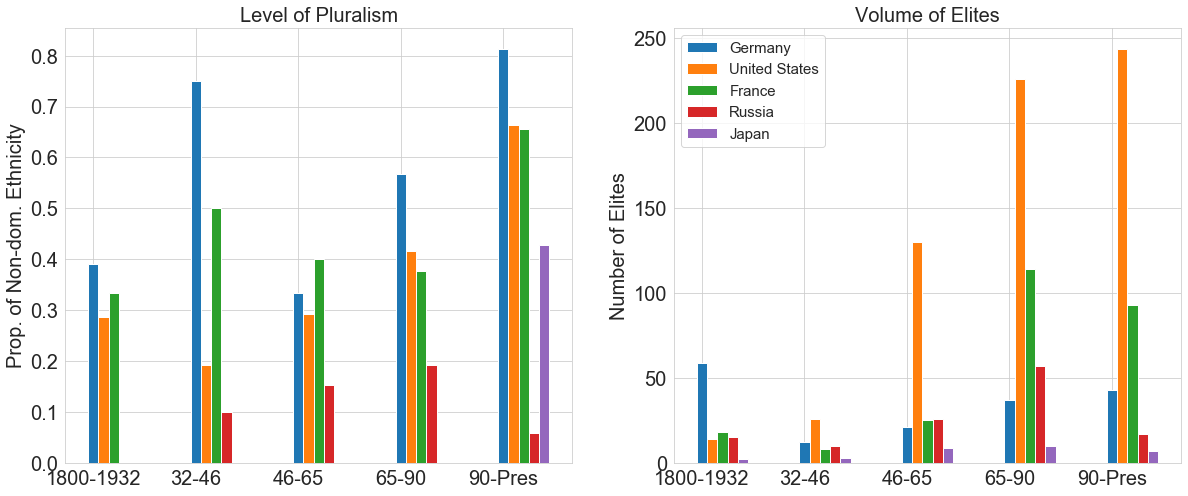

In [38]:
plt.figure(figsize=(20,8))
ticks = ["1800-1932", "32-46", "46-65", "65-90", "90-Pres"]
sns.set_style("whitegrid")
width = 0.1

plt.subplot(1,2,1)
plt.title("Level of Pluralism", fontsize = 20)
for i,p in enumerate(plural_scores.T):
    plt.bar(np.arange(5)+width*i,1-p, width = width, label = countries[i])
# plt.legend(fontsize = 15)
plt.xticks(range(5), ticks,fontsize= 20)
plt.yticks(fontsize= 20)
plt.ylabel("Prop. of Non-dom. Ethnicity",fontsize= 20)

plt.subplot(1,2,2)
plt.title("Volume of Elites", fontsize = 20)
for i,s in enumerate(size.T):
    plt.bar(np.arange(5)+width*i,s, width = width, label = countries[i])
plt.legend(fontsize = 15)
plt.xticks(range(5), ticks,fontsize= 20)
plt.yticks(fontsize= 20)
plt.ylabel("Number of Elites",fontsize= 20)

# plt.savefig("figures/pluralism.png")

In [39]:
df_pairings = []
for i,b  in enumerate(BS):
    pairings = Counter(zip(b.countries.values, b.ethnicity.values))
    pairings = pd.DataFrame([[k[0], k[1], v] for k,v in pairings.items()]  , columns =["country","ethnicity","count"])
    df_pairings.append( pairings )

In [40]:
for i in df_pairings:
    i.sort_values("count", ascending = False, inplace= True)
df_pairings[0].iloc[:8]

,country,ethnicity,count
0,Germany,Germanic,36
2,Russia,EastEuropean,15
3,Germany,Anglo,14
23,France,French,12
18,Italy,Italian,11
1,United States,Anglo,10
11,Germany,French,5
13,Poland,EastEuropean,5
